In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
# import pymap3d as pm

from scipy.signal import savgol_filter
%matplotlib inline

def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def to_euler(x, y, z, w):
    """Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])

# BELOK

In [3]:
# import rosbag
bag = rosbag.Bag('2021-02-11-14-58-54.bag')
# print(bag)
reverse_index = False
bag.get_type_and_topic_info()

TypesAndTopicsTuple(msg_types={'agv_container/State_Estimator': '46c89a7bcb3e7f325f4578b8f966f0b4', 'diagnostic_msgs/DiagnosticArray': '60810da900de1dd6ddd437c3503511da', 'dynamic_reconfigure/Config': '958f16a05573709014982821e6822580', 'dynamic_reconfigure/ConfigDescription': '757ce9d44ba8ddd801bb30bc456f946f', 'geometry_msgs/TwistStamped': '98d34b0043a2093cf9d9345ab6eef12e', 'nav_msgs/Odometry': 'cd5e73d190d741a2f92e81eda573aca7', 'rosgraph_msgs/Log': 'acffd30cd6b6de30f120938c17c593fb', 'sensor_msgs/Imu': '6a62c6daae103f4ff57a132d6f95cec2', 'sensor_msgs/NavSatFix': '2d3a8cd499b9b4a0249fb98fd05cfa48', 'sensor_msgs/TimeReference': 'fded64a0265108ba86c3d38fb11c0c16'}, topics={'/diagnostics': TopicTuple(msg_type='diagnostic_msgs/DiagnosticArray', message_count=56, connections=1, frequency=1.0014313652598221), '/fix': TopicTuple(msg_type='sensor_msgs/NavSatFix', message_count=281, connections=1, frequency=4.997318038248039), '/fix2': TopicTuple(msg_type='sensor_msgs/NavSatFix', message_co

In [4]:
print(bag)

path:        2021-02-11-14-58-54.bag
version:     2.0
duration:    56.4s
start:       Feb 11 2021 14:58:54.61 (1613030334.61)
end:         Feb 11 2021 14:59:51.05 (1613030391.05)
size:        1.8 MB
messages:    6199
compression: none [3/3 chunks]
types:       agv_container/State_Estimator         [46c89a7bcb3e7f325f4578b8f966f0b4]
             diagnostic_msgs/DiagnosticArray       [60810da900de1dd6ddd437c3503511da]
             dynamic_reconfigure/Config            [958f16a05573709014982821e6822580]
             dynamic_reconfigure/ConfigDescription [757ce9d44ba8ddd801bb30bc456f946f]
             geometry_msgs/TwistStamped            [98d34b0043a2093cf9d9345ab6eef12e]
             nav_msgs/Odometry                     [cd5e73d190d741a2f92e81eda573aca7]
             rosgraph_msgs/Log                     [acffd30cd6b6de30f120938c17c593fb]
             sensor_msgs/Imu                       [6a62c6daae103f4ff57a132d6f95cec2]
             sensor_msgs/NavSatFix                 [2d3a8cd499b9

In [5]:
# sesuatu=[]
for topic, msg, _ in bag.read_messages(topics=['/state_estimator']):
    sesuatu.append(msg)
    #     x.append(msg.x_est)
#     y.append(msg.y_est)
# #     x.append(msg.px)
# #     y.append(msg.py)
#     yaw.append(msg.yaw_gnss_fr)
#     t.append(msg.header.stamp.to_sec())
print(sesuatu[0])

header: 
  seq: 105
  stamp: 
    secs: 1613030334
    nsecs: 911346912
  frame_id: "state_estimator"
x_est: 784360.3639663889
y_est: 9239925.990469787
v_est: 0.019009720287122493
yaw_est: 0.0
yaw_gnss_fr: 1.4101419737792424


## CHECK 

In [5]:
# IMU
yawc_imu = 0.0
# yawc_compass = -np.pi/2 # INI DICEK LAGI !
yawc_compass = 0
sign = 1.0

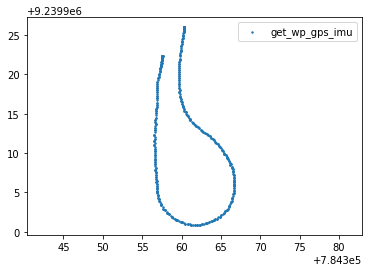

In [6]:
# lat0, lon0, h0 = -6.8712, 107.5738, 768
gps_t = []
gps_pos = []
gps_cov = []

x = []
y = []
yaw = []
t = []
for topic, msg, _ in bag.read_messages(topics=['/state_estimator']):
    x.append(msg.x_est)
    y.append(msg.y_est)
#     x.append(msg.px)
#     y.append(msg.py)
    yaw.append(msg.yaw_gnss_fr)
    t.append(msg.header.stamp.to_sec())

x = np.array(x)
y = np.array(y)
yaw = wrap_angle(np.array(yaw) * sign - yawc_compass)
t = np.array(t)

# lim = [0, -1]
plt.scatter(x,y,s=2., label='get_wp_gps_imu')
plt.legend()
plt.axis("equal")
plt.show()

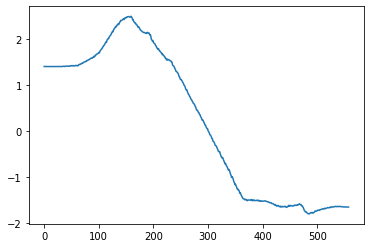

In [7]:
plt.plot(yaw)

In [8]:
# Filter the waypoints and remove the outlier !
X = np.copy(x)
Y = np.copy(y)
# Y = Y + 1
T = np.copy(t)
YAW = np.copy(yaw)
if reverse_index:
    YAW = YAW + np.pi
    YAW = wrap_angle(YAW)
    X = np.flip(X)
    Y = np.flip(Y)
    T = np.flip(T)
    YAW = np.flip(YAW)

'''for m in range(6):
    X_filtered = savgol_filter(X, 51, 3)
    Y_filtered = savgol_filter(Y, 51, 3)
    dist = np.sqrt((X_filtered - X)**2 + (Y_filtered - Y)**2)
    X = X[dist <= 0.5]
    Y = Y[dist <= 0.5]
    T = T[dist <= 0.5]
    # YAW = YAW[dist <= 0.5]
    if m % 1 == 0:
        None
#         plt.scatter(x, y, label='Raw Data', s=0.5,color='red')
#         plt.plot(X, Y, label='Outlier Rejection')
#         plt.legend()
#         plt.title('Iterasi ke-{}'.format(m))
#         plt.show()
plt.scatter(x, y, label='Raw Data', s=0.5,color='red')
plt.plot(X, Y, label='Outlier Rejection')
plt.legend()
plt.title('Iterasi ke-{}'.format(m))
plt.show()'''

"for m in range(6):\n    X_filtered = savgol_filter(X, 51, 3)\n    Y_filtered = savgol_filter(Y, 51, 3)\n    dist = np.sqrt((X_filtered - X)**2 + (Y_filtered - Y)**2)\n    X = X[dist <= 0.5]\n    Y = Y[dist <= 0.5]\n    T = T[dist <= 0.5]\n    # YAW = YAW[dist <= 0.5]\n    if m % 1 == 0:\n        None\n#         plt.scatter(x, y, label='Raw Data', s=0.5,color='red')\n#         plt.plot(X, Y, label='Outlier Rejection')\n#         plt.legend()\n#         plt.title('Iterasi ke-{}'.format(m))\n#         plt.show()\nplt.scatter(x, y, label='Raw Data', s=0.5,color='red')\nplt.plot(X, Y, label='Outlier Rejection')\nplt.legend()\nplt.title('Iterasi ke-{}'.format(m))\nplt.show()"

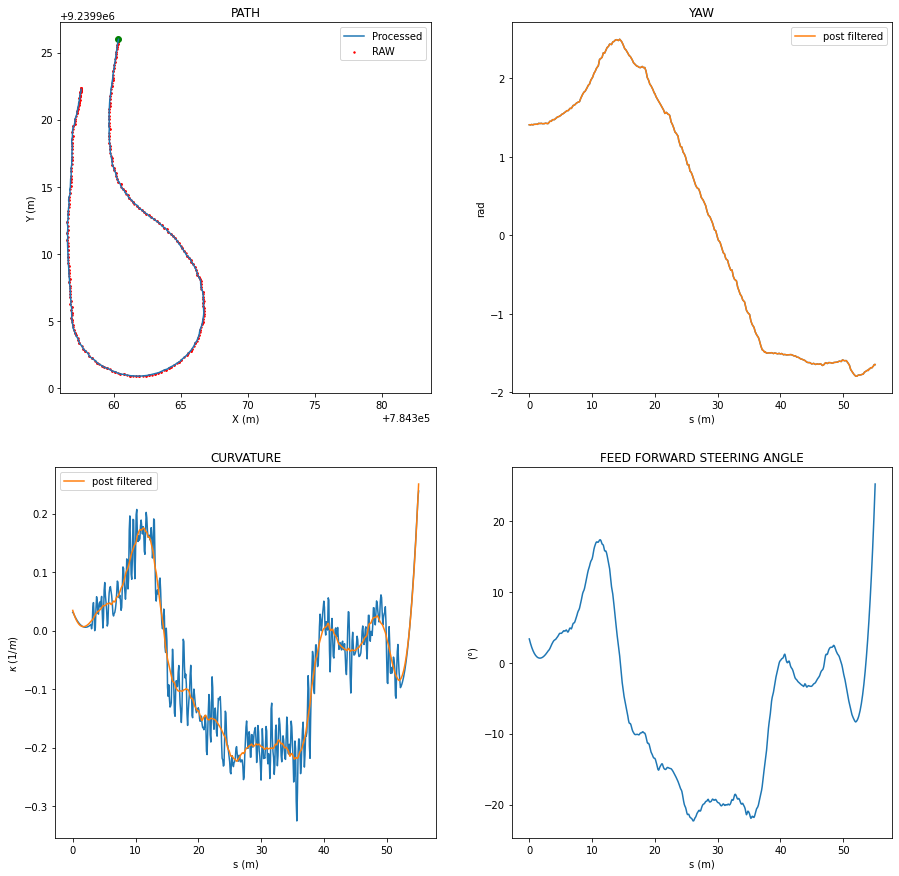

In [9]:
num_f = 61

dst = 0.1

wp_x = [X[0]]
wp_y = [Y[0]]
wp_yaw = [YAW[0]]
for i in range(1, X.shape[0]):
    dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
    while dist >= dst:
    #if dist >= dst:
        wp_x.append(wp_x[-1] + dst*(X[i] - wp_x[-1])/dist)
        wp_y.append(wp_y[-1] + dst*(Y[i] - wp_y[-1])/dist)
        wp_yaw.append(wp_yaw[-1] + dst*(YAW[i] - wp_yaw[-1])/dist)
        dist = np.sqrt((X[i] - wp_x[-1])**2 + (Y[i] - wp_y[-1])**2)
wp_x = np.array(wp_x)
wp_y = np.array(wp_y)
wp_yaw = np.array(wp_yaw)
temp = np.copy(wp_yaw)
wp_yaw = np.zeros_like(wp_x)
diffx = wp_x[2:] - wp_x[:-2]
diffy = wp_y[2:] - wp_y[:-2]
wp_yaw[1:-1] = np.arctan2(diffy, diffx)
wp_yaw[0] = wp_yaw[1]
wp_yaw[-1] = wp_yaw[-2]

wp_x_f = savgol_filter(wp_x, num_f, 3)
wp_y_f = savgol_filter(wp_y, num_f, 3)
wp_yaw_f = wrap_angle(savgol_filter(np.unwrap(wp_yaw), num_f, 3))

s = np.zeros(wp_x.shape[0])
for i in range(1, s.shape[0]):
    s[i] = s[i-1] + np.sqrt((wp_x[i] - wp_x[i-1])**2 + (wp_y[i] - wp_y[i-1])**2)

curvature = np.gradient(np.unwrap(wp_yaw_f), s)
curvaturef = savgol_filter(curvature, num_f, 3)
steer = np.arcsin(1.7 * curvaturef)*180/np.pi

# Limiting the steering angle
steer[steer > 35.] = 35
steer[steer < -28.] = -28.

wp_yaw = np.copy(temp)
# wp_yaw_f = wrap_angle(savgol_filter(np.unwrap(wp_yaw), num_f, 3))
wp_yaw_f = np.copy(wp_yaw)

width = 15
height = 15
plt.figure(figsize=(width, height))

plt.subplot(2,2,1)
plt.plot(wp_x, wp_y, label='Processed')
plt.scatter(x, y, color='red',s=2., label='RAW')
plt.scatter(wp_x[0], wp_y[0], c="g", s=35)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.title("PATH")
plt.axis('square')

plt.subplot(2,2,2)
plt.plot(s, wp_yaw)
plt.plot(s, wp_yaw_f, label='post filtered')
plt.title("YAW")
plt.xlabel('s (m)')
plt.ylabel('rad')
plt.legend()

plt.subplot(2,2,3)
plt.plot(s, curvature)
plt.plot(s, curvaturef, label='post filtered')
plt.legend()
plt.title("CURVATURE")
plt.xlabel('s (m)')
plt.ylabel(r'$\kappa\;(1/m)$')

plt.subplot(2,2,4)
plt.plot(s, steer)
plt.title("FEED FORWARD STEERING ANGLE")
plt.xlabel('s (m)')
plt.ylabel(r'$(\degree)$')

#plt.savefig('waypoints.png', dpi=600, transparent=True)
plt.show()

## INTERPOLATING THE WAYPOINTS

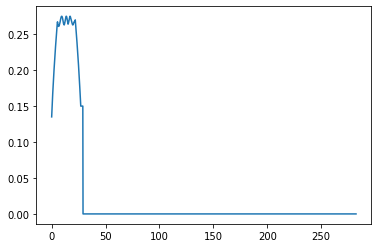

In [9]:
# # THROTTLEEEEE

# # Generate the velocity
v0 = 0.135 #m/s ~ 1.8 km/jam
vstop = 0.15
vmax = 0.275 #m/s ~ 5.4 km/jam
accel = 0.005 #m/s2
num = wp_x_f.shape[0]
vel = [v0]
const = 7.
for i in range(1, num):
    vel.append(min(np.sqrt(vel[-1]**2 + 2*accel*dst), vmax / (1 + const*curvaturef[i]**2)))
vel = np.array(vel)

for i in range(num):
    if s[i] >= 29:
        vel[i] = 0.0
    elif s[i] >= 22:
        vel[i] = max(np.sqrt(max(vel[i-1]**2 - 2*accel*dst, 0.0)), vstop)

plt.plot(s, vel)

In [10]:
waypoints_np = np.empty((wp_x_f.shape[0], 5))
waypoints_np[:,0] = wp_x_f
waypoints_np[:,1] = wp_y_f
waypoints_np[:,2] = wp_yaw_f
waypoints_np[:,3] = vel
waypoints_np[:,4] = curvaturef

In [11]:
INTERP_DISTANCE_RES = 0.01 # distance between interpolated points

# Linear interpolation computations
# Compute a list of distances between waypoints
wp_distance = []   # distance array
for i in range(1, waypoints_np.shape[0]):
    wp_distance.append(
            np.sqrt((waypoints_np[i, 0] - waypoints_np[i-1, 0])**2 +
                    (waypoints_np[i, 1] - waypoints_np[i-1, 1])**2))
wp_distance.append(0)  # last distance is 0 because it is the distance
                       # from the last waypoint to the last waypoint

# Linearly interpolate between waypoints and store in a list
wp_interp      = []    # interpolated values 
                       # (rows = waypoints, columns = [x, y, v])
wp_interp_hash = []    # hash table which indexes waypoints_np
                       # to the index of the waypoint in wp_interp
interp_counter = 0     # counter for current interpolated point index
for i in range(waypoints_np.shape[0] - 1):
    # Add original waypoint to interpolated waypoints list (and append
    # it to the hash table)
    wp_interp.append(list(waypoints_np[i]))
    wp_interp_hash.append(interp_counter)   
    interp_counter+=1

    # Interpolate to the next waypoint. First compute the number of
    # points to interpolate based on the desired resolution and
    # incrementally add interpolated points until the next waypoint
    # is about to be reached.
    num_pts_to_interp = int(np.floor(wp_distance[i] /\
                                 float(INTERP_DISTANCE_RES)) - 1)
    wp_vector = waypoints_np[i+1] - waypoints_np[i]
    wp_uvector = wp_vector / np.linalg.norm(wp_vector)
    for j in range(num_pts_to_interp):
        next_wp_vector = INTERP_DISTANCE_RES * float(j+1) * wp_uvector
        wp_interp.append(list(waypoints_np[i] + next_wp_vector))
        interp_counter+=1
# add last waypoint at the end
wp_interp.append(list(waypoints_np[-1]))
wp_interp_hash.append(interp_counter)   
wp_interp = np.array(wp_interp)
wp_interp_hash = np.array(wp_interp_hash)
interp_counter+=1

In [13]:
np.save('waypoints/2021-02-19-08-10-05', wp_interp)
wp_interp.shape

(25583, 5)

In [14]:
wp_interp

array([[ 7.84309070e+05,  9.23974934e+06,  9.93495206e-02,
         1.35000000e-01,  4.41245618e-02],
       [ 7.84309079e+05,  9.23974934e+06,  9.94867066e-02,
         1.35361710e-01,  4.31256567e-02],
       [ 7.84309089e+05,  9.23974934e+06,  9.96238925e-02,
         1.35723420e-01,  4.21267516e-02],
       ...,
       [ 7.84306525e+05,  9.23973841e+06, -7.32384676e-01,
         0.00000000e+00,  2.80395211e-01],
       [ 7.84306528e+05,  9.23973841e+06, -7.33270296e-01,
         0.00000000e+00,  2.83695387e-01],
       [ 7.84306536e+05,  9.23973838e+06, -7.35365401e-01,
         0.00000000e+00,  2.91502590e-01]])

In [1]:
import numpy as np

In [27]:
A = np.gradient(np.array([3,1.5]), np.array([5,2]))
A

array([0.5, 0.5])